Mounted at /content/drive
Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 339s 7s/step - accuracy: 0.3343 - loss: 7.7602 - val_accuracy: 0.4067 - val_loss: 6.9161 - learning_rate: 1.0000e-04
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 558ms/step - accuracy: 0.3728 - loss: 6.7333 - val_accuracy: 0.4367 - val_loss: 6.0432 - learning_rate: 1.0000e-04
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 567ms/step - accuracy: 0.4118 - loss: 5.8934 - val_accuracy: 0.4467 - val_loss: 5.3033 - learning_rate: 1.0000e-04
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 700ms/step - accuracy: 0.4386 - loss: 5.1636 - val_accuracy: 0.4033 - val_loss: 4.6685 - learning_rate: 1.0000e-04
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 691ms/step - accuracy: 0.4397 - loss: 4.5503 - val_accuracy: 0.4300 - val_loss: 4.1386 - learning_rate: 1.0000e-04
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 575ms/step - accuracy: 0.4216 - loss: 4.0562 - val_accuracy: 0.4333 - val_loss: 3.6800 - learning_rate: 1.0000e-04
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.4705

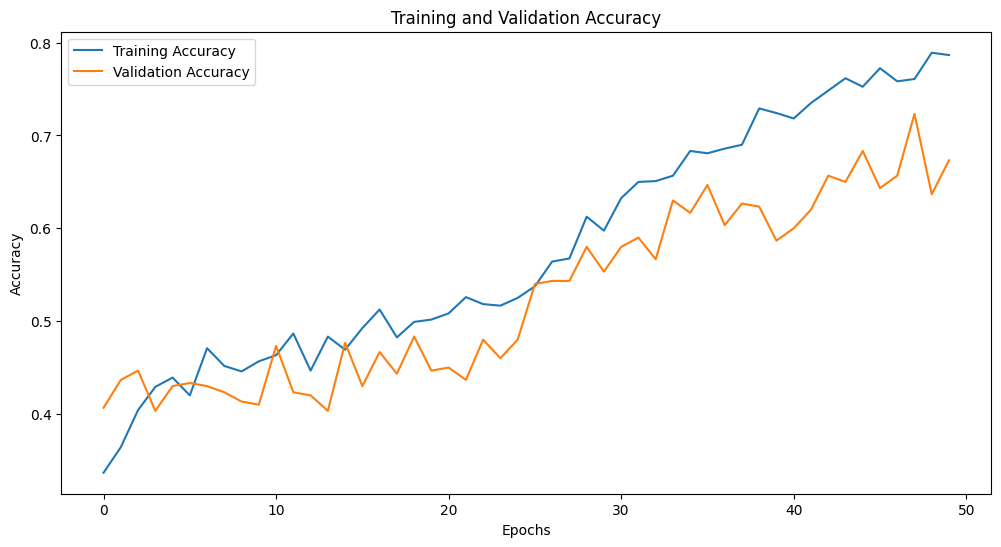

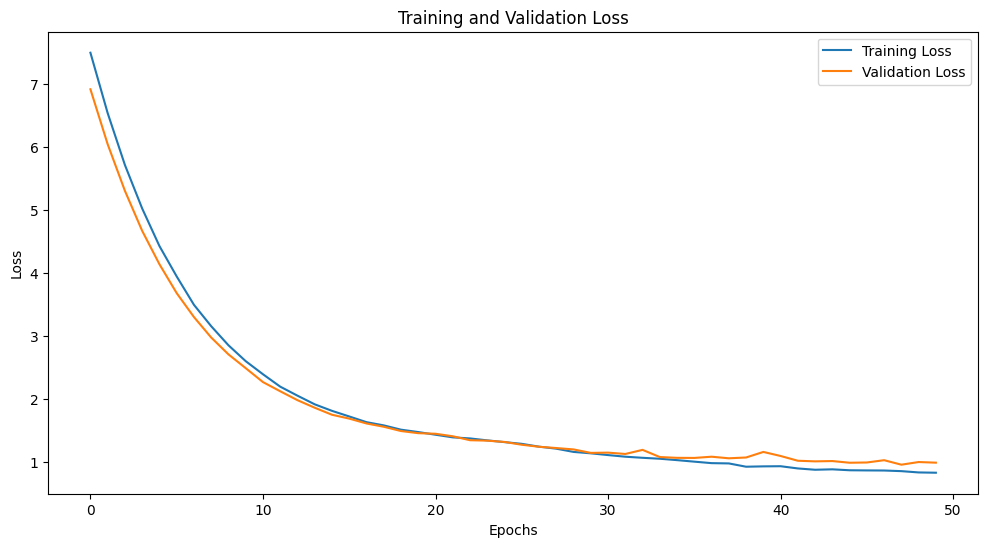

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset directory path
dataset_path = '/content/drive/MyDrive/sinusities/sinusities_dataset'

# Dataset preprocessing with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Create a validation set
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Input size for VGG16
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Training subset
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Input size for VGG16
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Validation subset
)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
predictions = Dense(3, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
]

# Train the model (initial training)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

# Fine-tune the model
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the fine-tuned model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

# Save the model
model.save('/content/drive/MyDrive/sinusities/vgg16_model.h5')

# Combine histories for plotting
history.history['accuracy'] += fine_tune_history.history['accuracy']
history.history['val_accuracy'] += fine_tune_history.history['val_accuracy']
history.history['loss'] += fine_tune_history.history['loss']
history.history['val_loss'] += fine_tune_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
